In [32]:
import os
path = os.getcwd()

if path[1:5] == 'Home':
    %run /Home/siv30/wad005/master/GRB/src/harvest_matlab_data.ipynb
    %run /Home/siv30/wad005/master/GRB/src/background_rates.ipynb
    %run /Home/siv30/wad005/master/GRB/src/dau_det_distribution.ipynb

else:
    %run /Users/andreas/phys/master/GRB/src/harvest_matlab_data.ipynb
    %run /Users/andreas/phys/master/GRB/src/background_rates.ipynb
    %run /Users/andreas/phys/master/GRB/src/dau_det_distribution.ipynb


all UiB paths loaded


<Figure size 800x500 with 0 Axes>


all UiB paths loaded
read_matlab_file.ipynb loaded successfully!

all UiB paths loaded

all UiB paths loaded
read_matlab_file.ipynb loaded successfully!

all UiB paths loaded
read_matlab_file.ipynb loaded successfully!
convert_erg.ipynb loaded successfully!

all UiB paths loaded
read_matlab_file.ipynb loaded successfully!

all UiB paths loaded
read_matlab_file.ipynb loaded successfully!
convert_erg.ipynb loaded successfully!
safety_time.ipynb loaded successfully!

all UiB paths loaded

all UiB paths loaded
read_matlab_file.ipynb loaded successfully!

all UiB paths loaded
read_matlab_file.ipynb loaded successfully!

all UiB paths loaded

all UiB paths loaded
read_matlab_file.ipynb loaded successfully!

all UiB paths loaded
read_matlab_file.ipynb loaded successfully!

all UiB paths loaded
read_matlab_file.ipynb loaded successfully!
convert_erg.ipynb loaded successfully!

all UiB paths loaded
read_matlab_file.ipynb loaded successfully!

all UiB paths loaded
read_matlab_file.ipynb loaded 

In [5]:
def harvest_data(fn=None,T0=None):
    data = scipy.io.loadmat(path_m+fn)['out_data']
    df = pd.DataFrame(data=data)
    df.rename(columns={0:'year',1:'month',2:'day',3:'hour',4:'minute',5:'second',6:'erg',7:'dau',8:'det'},inplace=True)
    df = df.convert_dtypes()
    dt_column = pd.to_datetime(df[['year', 'month', 'day', 'hour', 'minute', 'second']].astype(dtype=str))
    df['datetime'] = dt_column
    T0 = datetime.fromisoformat(T0)
    tus = df['datetime']-T0
    df['tus'] = tus
    df['tus'] = df['tus'].dt.total_seconds()
    df['dau'] = df['dau'].to_numpy()+1 #index starting now at 1
    df['det'] = df['det'].to_numpy()+1 #index starting now at 1
    df = make_adr(df)
    
    df.sort_values(by=['adr','tus'],inplace=True,ignore_index=True)
    print('dau/det starting from index 1')
    print('tus array given in seconds')
    return df
    
    tus,erg,dau,det = df['tus'].to_numpy(),df['erg'].to_numpy(),df['dau'].to_numpy(),df['det'].to_numpy()
    keV,abc = convert_erg(erg,dau,det,T0)
    df['keV'] = keV
    df['tus'] = df['tus'].to_numpy()*1e6

    st,dt = get_st(df),get_dt(df)
    df['st']=st
    df['dt']=dt

    flag = get_flag(df)
    df['flag']=flag
    print('safety time: ',np.round((len(np.where(flag==True)[0])/len(flag))*100,3), '% removed')
    df.drop(labels=np.where(flag==True)[0],inplace=True)
    df.sort_values(by='tus',inplace=True,ignore_index=True)
    df['tus'] = df['tus'].to_numpy()/1e6
    print('tus given in seconds')
    

In [11]:
df = harvest_data(fn='2021_12_11_13_10_1',T0='2021-12-11T13:10:01.323')
df.sort_values(by='tus',inplace=True)

dau/det starting from index 1
tus array given in seconds


In [12]:
d = np.diff(df['tus'].to_numpy())
mask = np.where(d>1)[0]

In [14]:
mask

array([ 31818,  73421, 122712])

In [13]:
df['tus'].to_numpy()[mask]

array([ 1.97086286,  6.18063222, 19.90964067])

tus array OK ...


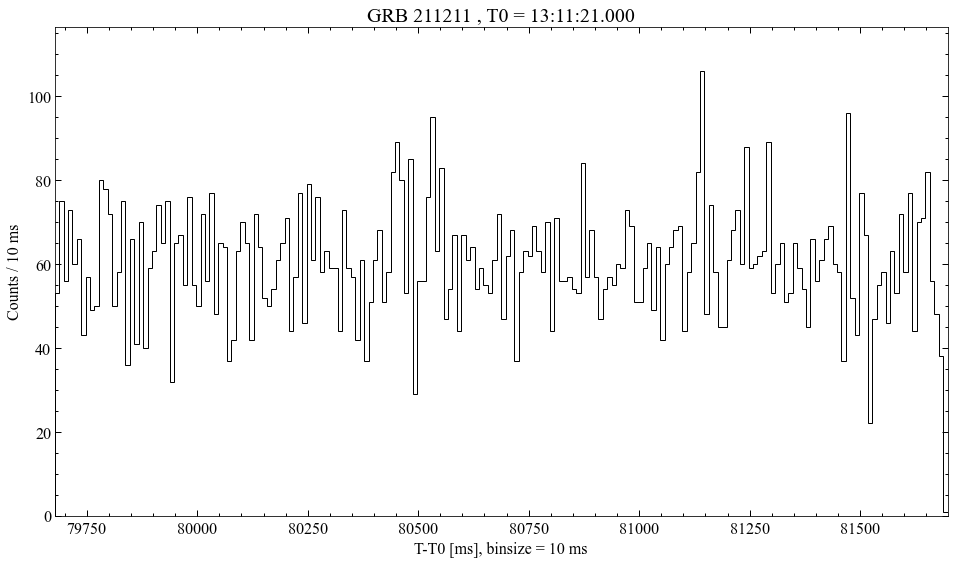

In [31]:
plot_HED(tus_arr=df['tus'].to_numpy()[122712+1:]*1e6,binsize=10,T0=datetime.fromisoformat('2021-12-11T13:10:01.323')+timedelta(seconds=79.677))

In [30]:
df['tus'].to_numpy()[122712+1]

79.67756641700001